In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/million-headlines/abcnews-date-text.csv


In [1]:
import pandas as pd

data = pd.read_csv('/kaggle/input/million-headlines/abcnews-date-text.csv', error_bad_lines=False)
data['publish_date'] = pd.to_datetime(data.publish_date, format='%Y%m%d')
data_text = data[['headline_text']]
data_text['index'] = data_text.index
documents = data_text

#  Detect Common words in news headlines 

Preprocess headlines
* Stemming and lemmatisation 
* Remove stopwords 
* Exclude words that have less than 3 characters and words that show up in more than half of the headlines 
* Only include the top 100000 most frequent words 

Generate wordcloud using the wordcloud package

In [2]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [5]:
STOPWORDS = gensim.parsing.preprocessing.STOPWORDS
def preprocess(headline):
    result = []
    for token in gensim.utils.simple_preprocess(headline):
        if token not in STOPWORDS and len(token) >= 3:
            result.append(lemmatize_stemming(token))
    return result

In [6]:
processed_docs = documents.headline_text.map(preprocess)

In [17]:
corpus = []
for headline in processed_docs.values:
    corpus.extend(headline)
corpus[:10]

['aba',
 'decid',
 'communiti',
 'broadcast',
 'licenc',
 'act',
 'wit',
 'awar',
 'defam',
 'call']

Use WordClound to detect common buzz words in news headlines
* Words are stemmed/ lemmatized 
* Stopwords are removed

In [18]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    background_color='white',
    stopwords=set(STOPWORDS),
    max_words=100,
    max_font_size=100, 
    scale=3,
    random_state=1)

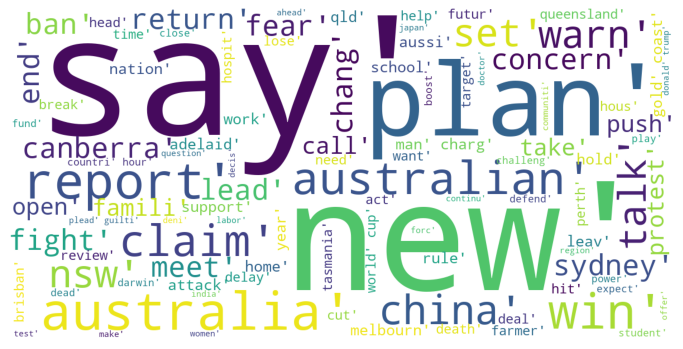

In [20]:
import matplotlib.pyplot as plt 

wordcloud=wordcloud.generate(str(corpus))
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Common buzz words appear in news headlines include "Plan", "New", "Australia", "Say", "Report" and "Claim" etc.

# Perform Sentiment Analysis on news headlines using NLTK VADER package 
* Lemmatisation and Removing stopwords are not necessary here because it might harm the analysis performance 

According to this [article](https://medium.com/data-science-blogs/stopwords-and-lexicon-normalization-for-sentiment-analysis-f9f10f0d4108#:~:text=VADER%20tends%20to%20outperform%20TextBlob,for%20pattern%20based%20sentiment%20analysis.), removing StopWords and Lemmatization actually made identifying negative reviews more difficult. Intuitively, it makes perfect sense. StopWords such as “not”, “very”, and “but” can be quite helpful when it comes to identifying negative emotions. Words with the same base roots such as “worse” and “bad” or “better” and “good” exhibit different emotional intensities but will be ignored after Lemmatization. 

Also, according to [Schumacher](https://opendatagroup.github.io/data%20science/2019/03/21/preprocessing-text.html#:~:text=The%20general%20rule%20for%20whether,improve%20performance%2C%20do%20not%20lemmatize.&text=For%20example%2C%20a%20popular%20sentiment,not%20be%20stemmed%20or%20lemmatized), "VADER, has different ratings depending on the form of the word and therefore the input should not be stemmed or lemmatized."

* Classification threshold 

Based on "About the Scoring" section on this [github page](https://github.com/cjhutto/vaderSentiment), if compound score is larger than 0.05, the headline will be classified as positive; if compound score is smaller than -0.05 it will be negative and in between will be neutral. 

In [4]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [5]:
# sentiment analysis on headlines; result is a dictionary containing positive, neutral, negative and compound score 
data['sentiment_score'] = data['headline_text'].apply(lambda headline: sia.polarity_scores(headline))

# extract compound scores to a new column
data['compound_score']  = data['sentiment_score'].apply(lambda score_dict: score_dict['compound'])

# create a new column for sentiment labels 
data['sentiment_label'] = data['compound_score'].apply(lambda c: 'positive' if c >=0.05 else 'neutral' if c>-0.05 else 'negative')

# counts of sentiment labels
data['sentiment_label'].value_counts()

neutral     555859
negative    421148
positive    249251
Name: sentiment_label, dtype: int64

The above result shows that nearly half of the news headlines are neutral. While in the other half, there are more negative headlines identified than positive ones.

Visualize sentiment score over time 

In [27]:
monthly_avg = data.resample('M', on = 'publish_date').mean()
yearly_avg = data.resample('A', on = 'publish_date').mean()

In [30]:
monthly_avg.head()

,compound_score
publish_date,
2003-02-28,-0.081339
2003-03-31,-0.093607
2003-04-30,-0.064970
2003-05-31,-0.062888
2003-06-30,-0.054663


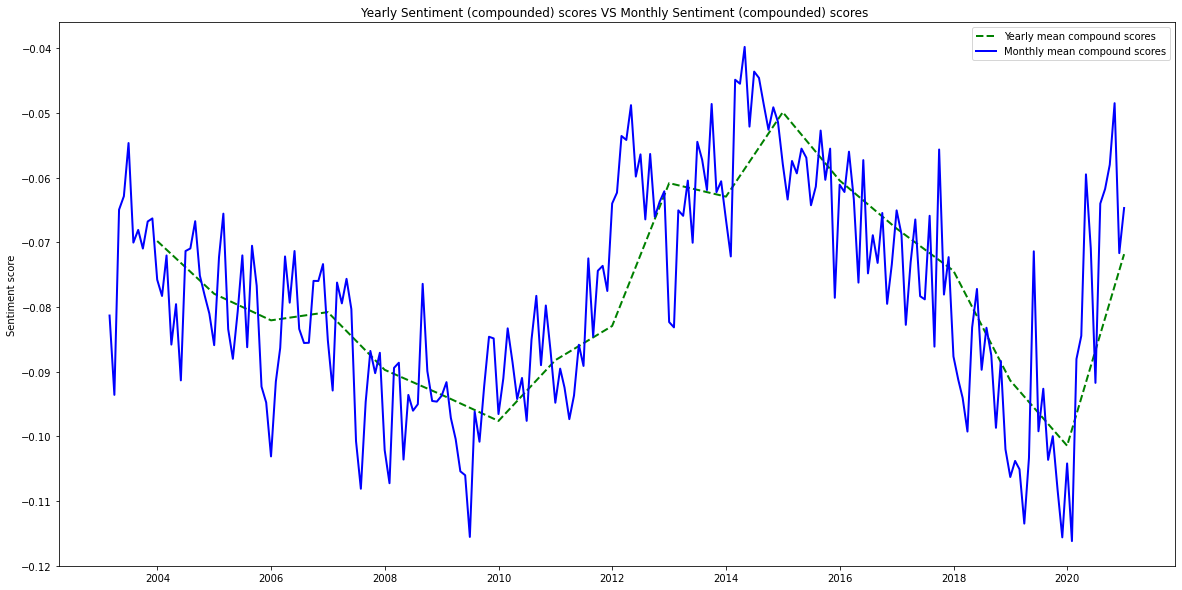

In [40]:
plt.figure(figsize = (20, 10))
plt.plot(yearly_avg.index, yearly_avg['compound_score'], color='green', linewidth = 2, linestyle='dashed', 
        label = 'Yearly mean compound scores')
plt.plot(monthly_avg.index, monthly_avg['compound_score'], color='blue', linewidth = 2,
        label = 'Monthly mean compound scores')
plt.legend()
plt.ylabel('Sentiment score')
plt.title('Yearly Sentiment (compounded) scores VS Monthly Sentiment (compounded) scores ')
plt.show()

There are two peaks (in 2012 and 2015) and two troughs (in 2010 and 2020). There might be some major events happening during that time and drive sentiment scores up and down. For example in 2020, sentiment score went down potentially because of COVID. 

# Further detect emotions from news headlines using the [NRCLex Package ](https://pypi.org/project/NRCLex/)

Emotional effects measured include the following:

* Fear
* Anger
* Anticipation
* Trust
* Surprise
* Positive
* Negative
* Sadness
* Disgust
* Joy



In [6]:
!pip install NRCLex
from nrclex import NRCLex

     |████████████████████████████████| 396 kB 420 kB/s eta 0:00:01
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=fd5554fe4b2a42dda6e0db266c3adadb4deb8628889c9f56213d5e47927ad079
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


In [8]:
# Retrieve emotion effects frequency (stored in a dictionary)
def emotion_freq(headline):
    result = {}
    # transform into a text object
    headline = NRCLex(headline)
    freq = headline.affect_frequencies
    for k, i in freq.items():
        result[k] = result.get(k, 0.0) + i 
    return result 

In [17]:
# Retrieve the highest emotion 
def emotion_highest(headline):
    headline = NRCLex(headline)
    top_emotion = headline.top_emotions[0][0]
    return top_emotion

In [10]:
headlines = data[['publish_date', 'headline_text']]
headlines['emotion'] = headlines['headline_text'].apply(emotion_freq)
headlines.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,publish_date,headline_text,emotion
0,2003-02-19,aba decides against community broadcasting lic...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
1,2003-02-19,act fire witnesses must be aware of defamation,"{'fear': 0.5, 'anger': 0.0, 'anticip': 0.0, 't..."
2,2003-02-19,a g calls for infrastructure protection summit,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
3,2003-02-19,air nz staff in aust strike for pay rise,"{'fear': 0.0, 'anger': 0.16666666666666666, 'a..."
4,2003-02-19,air nz strike to affect australian travellers,"{'fear': 0.0, 'anger': 0.5, 'anticip': 0.0, 't..."


In [11]:
# explode the dictionary into multiple columns 
data_nrc = pd.concat((data[['publish_date', 'headline_text']].copy(), headlines['emotion'].apply(pd.Series)), axis =1)
data_nrc.head()

,publish_date,headline_text,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,2003-02-19,aba decides against community broadcasting lic...,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.00,0.000000,NaN
1,2003-02-19,act fire witnesses must be aware of defamation,0.5,0.000000,0.0,0.000000,0.0,0.000000,0.250000,0.0,0.25,0.000000,NaN
2,2003-02-19,a g calls for infrastructure protection summit,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.333333,0.0,0.00,0.000000,0.333333
3,2003-02-19,air nz staff in aust strike for pay rise,0.0,0.166667,0.0,0.166667,0.0,0.166667,0.166667,0.0,0.00,0.166667,0.166667
4,2003-02-19,air nz strike to affect australian travellers,0.0,0.500000,0.0,0.000000,0.0,0.000000,0.500000,0.0,0.00,0.000000,NaN


In [18]:
# Count of emotion labels
data_nrc['top_emotion'] = data_nrc['headline_text'].apply(emotion_highest)
data_nrc['top_emotion'].value_counts()

fear            634658
positive        177281
trust           175457
negative        107356
anger            66811
anticipation     37605
surprise         21156
sadness           4099
joy               1204
disgust            631
Name: top_emotion, dtype: int64

ABC news headlines consists mostly of "negative emotion", where a large amount of headlines express a sense of fear and negativity. This makes sense because headlines might be reserved for large-scale disasterous events. However, almost one-thrid of them have a more postive tone, and show a sense of postivity and trust. 

In [19]:
data_nrc_monthly_avg = data_nrc.resample('M', on = 'publish_date').mean()
data_nrc_yearly_avg = data_nrc.resample('A', on = 'publish_date').mean()
emotions = ['fear', 'anger','anticipation', 'joy', 'surprise', 'positive', 'negative', 'sadness', 'disgust']

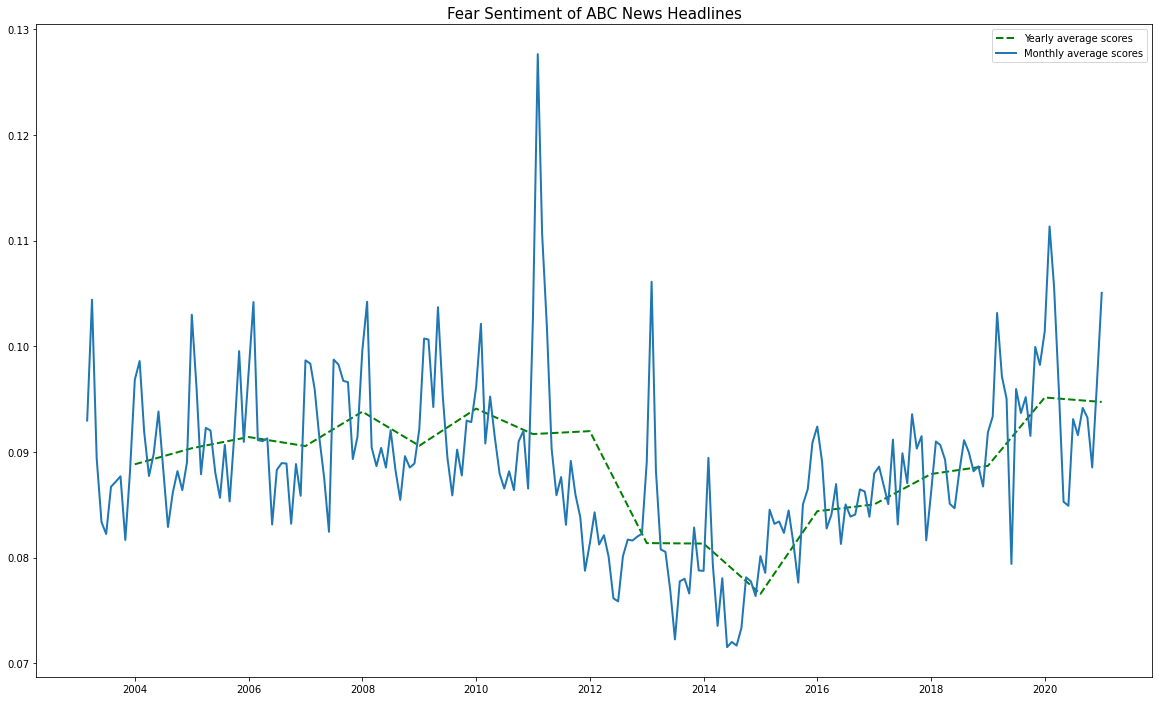

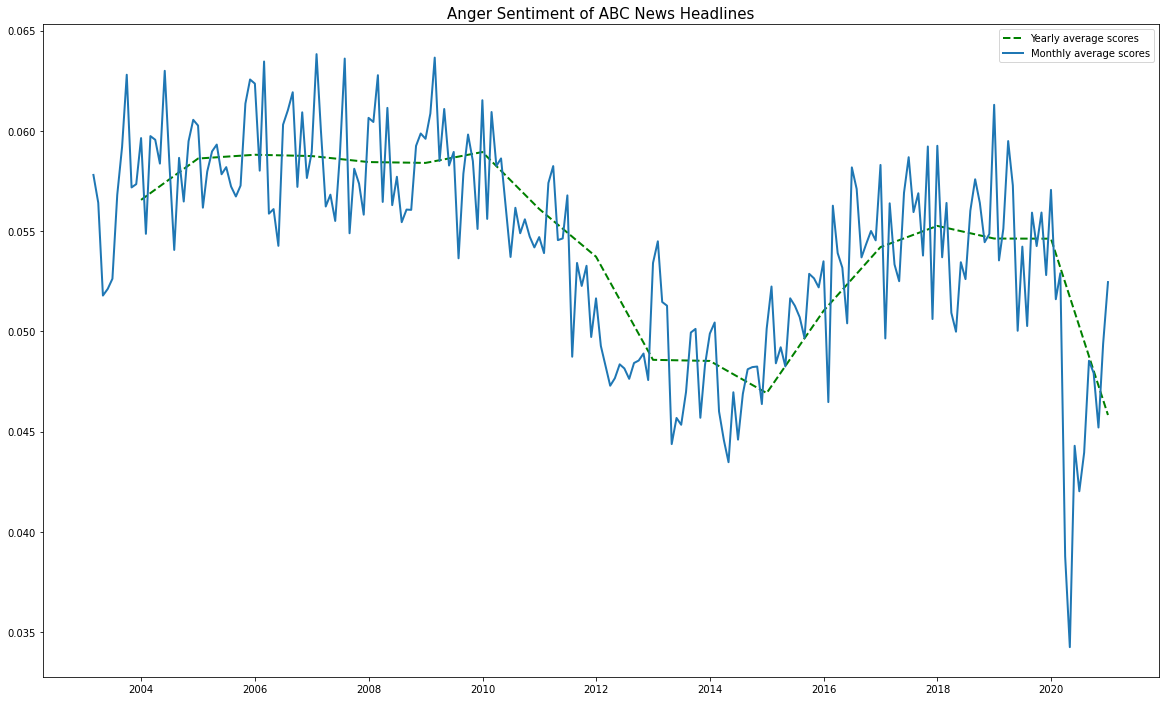

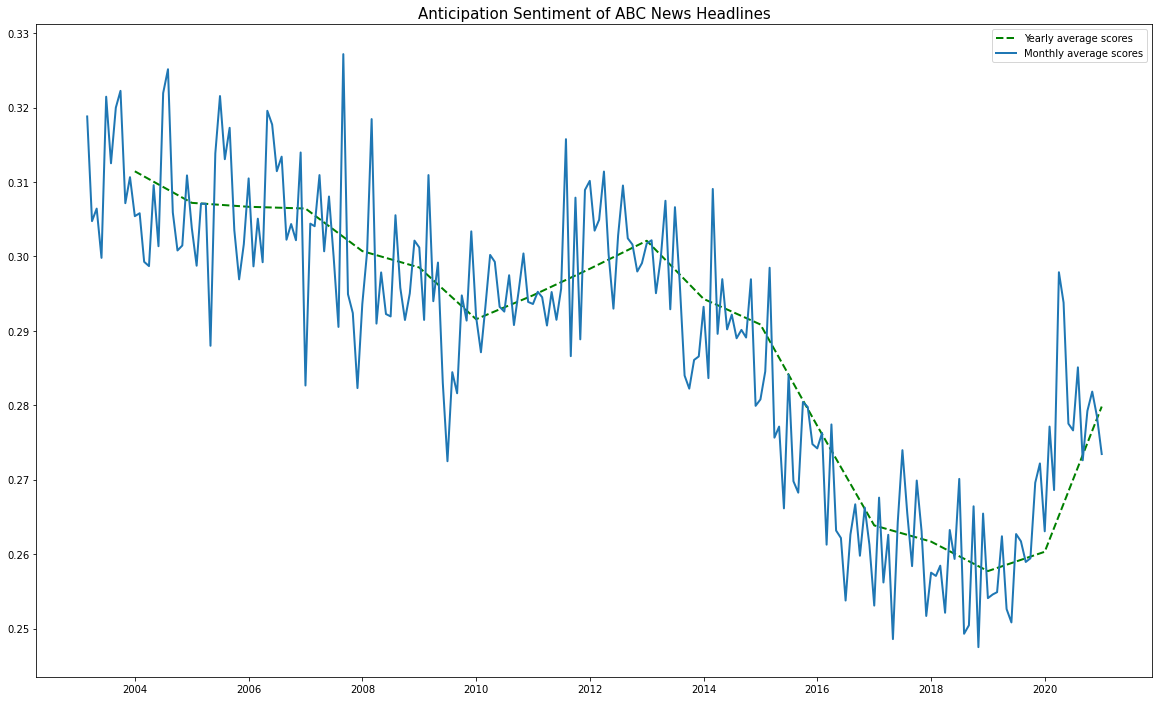

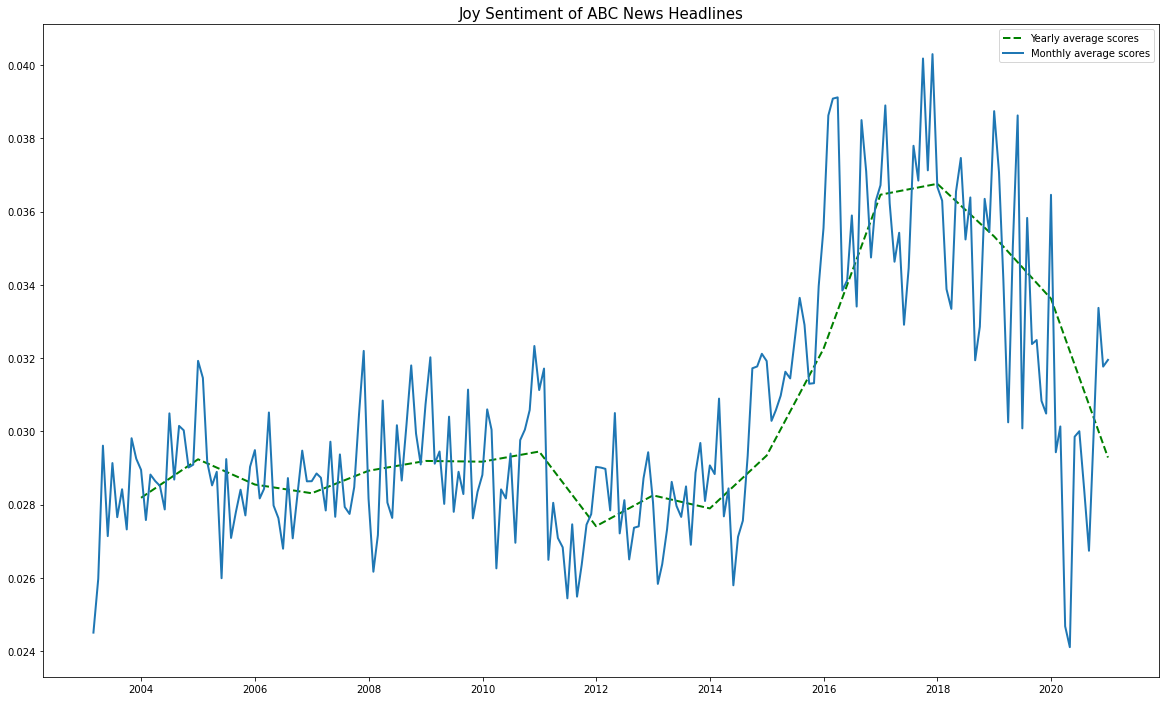

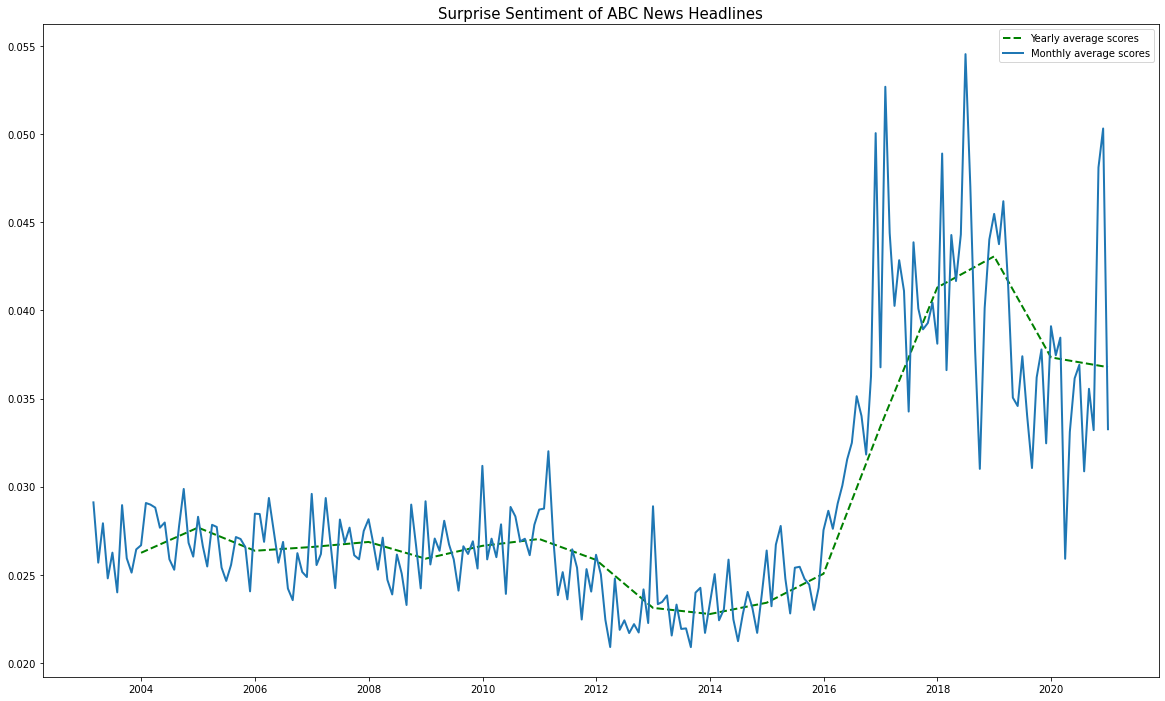

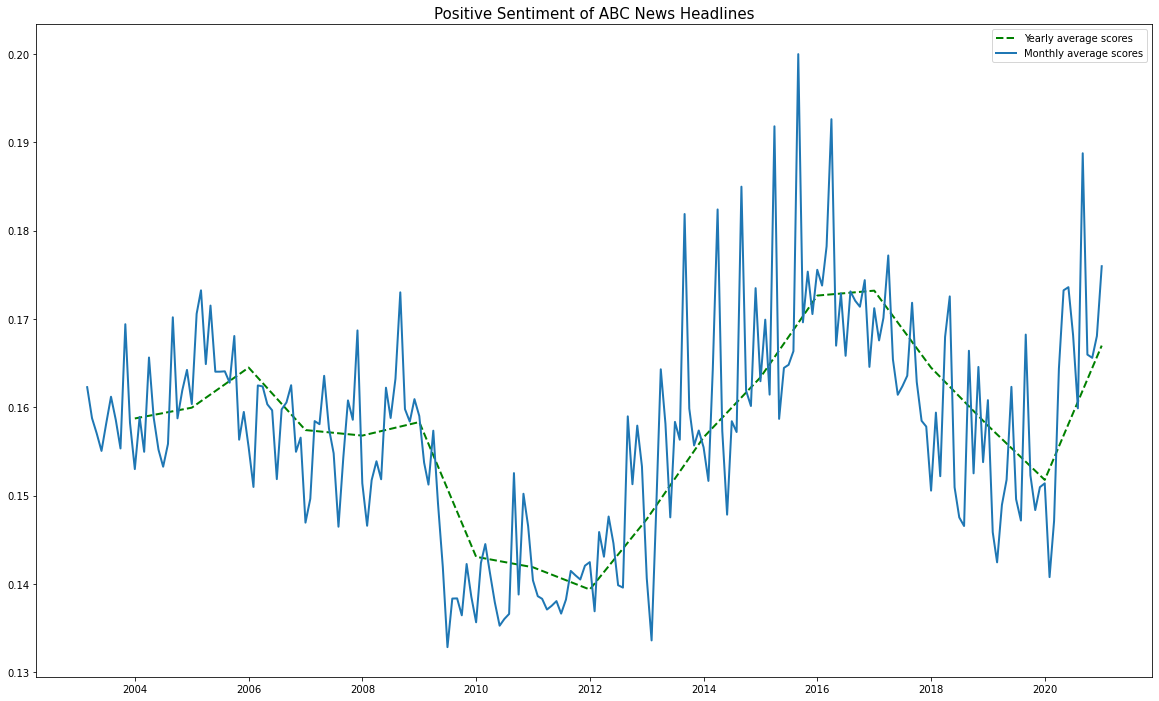

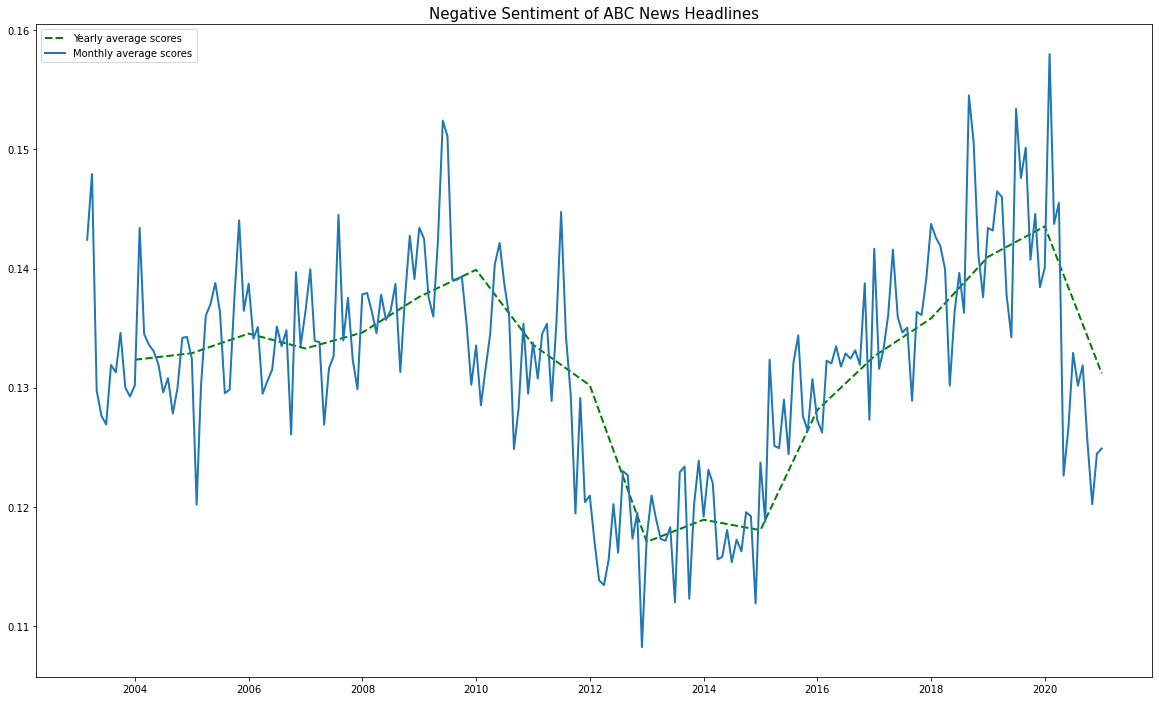

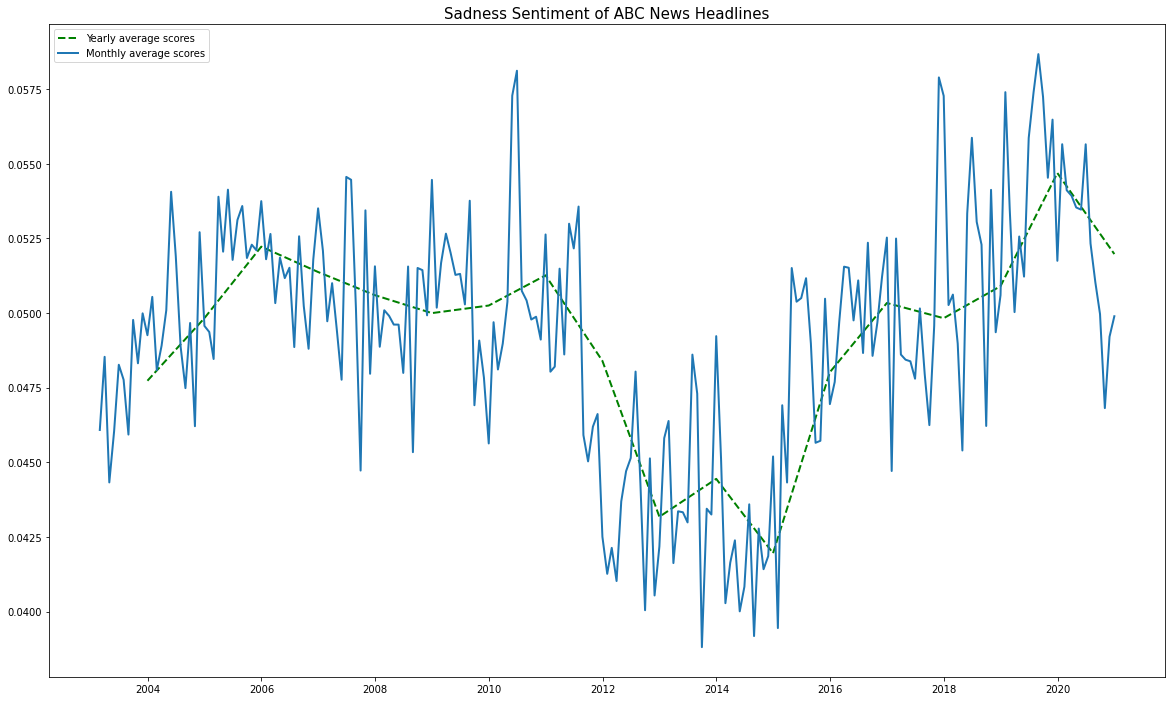

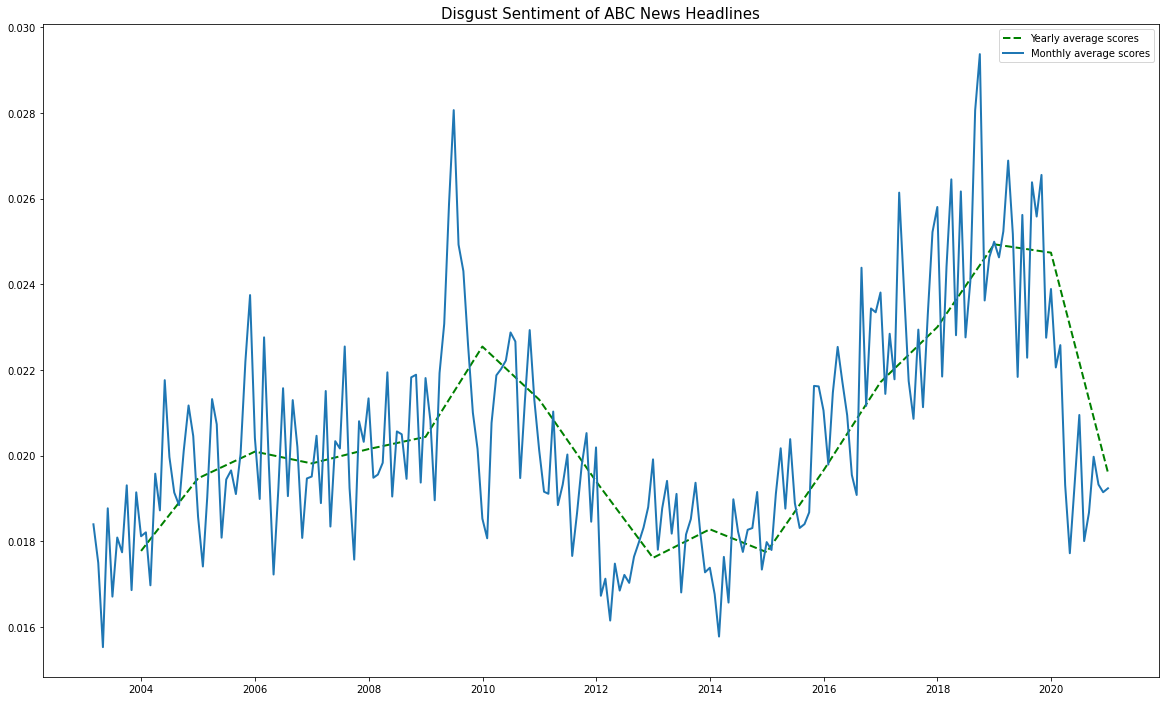

In [22]:
for emotion in emotions: 
    plt.figure(figsize=(20,12))
    plt.plot(data_nrc_yearly_avg.index,data_nrc_yearly_avg[emotion], color='green', linewidth=2, linestyle='dashed', 
             label='Yearly average scores')
    plt.plot(data_nrc_monthly_avg.index, data_nrc_monthly_avg[emotion], color = 'tab:blue', linewidth=2, 
             label='Monthly average scores')
    plt.title('{} Sentiment of ABC News Headlines'.format(emotion.title()), fontsize=15)
    plt.legend()
    plt.show()